Creating sample dataset...
Dataset shape: (200, 5)
Training samples: 140, Test samples: 60
PSO FEATURE SELECTION - BASED ON LEC5.PDF

Parameters: w=0.7, c1=2.0, c2=2.0
Particles: 3, Features: 5, Max Iterations: 10


>>> INITIALIZATION <<<
----------------------------------------------------------------------

Particle 1:
  Position: [1 0 1 0 1]
  Velocity: [ 0.2 -0.1  0.3 -0.2  0.1]
  Fitness:  0.5500

Particle 2:
  Position: [0 1 1 0 0]
  Velocity: [-0.1  0.2  0.1 -0.3 -0.2]
  Fitness:  0.5333

Particle 3:
  Position: [1 1 0 1 0]
  Velocity: [ 0.1  0.1 -0.2  0.3 -0.1]
  Fitness:  0.6667

>>> INITIAL GLOBAL BEST <<<
  Position: [1 1 0 1 0]
  Fitness:  0.6667
  Selected Features: [1, 2, 4]

>>> ITERATION 1 <<<
----------------------------------------------------------------------

Particle 1:
  New Position: [0 1 0 0 1]
  New Velocity: [ 0.14   1.196 -1.056  1.126 -1.196]
  New Fitness:  0.4667
  pBest: [1 0 1 0 1] (fitness: 0.5500)

Particle 2:
  New Position: [1 0 0 1 1]
  New Velocit

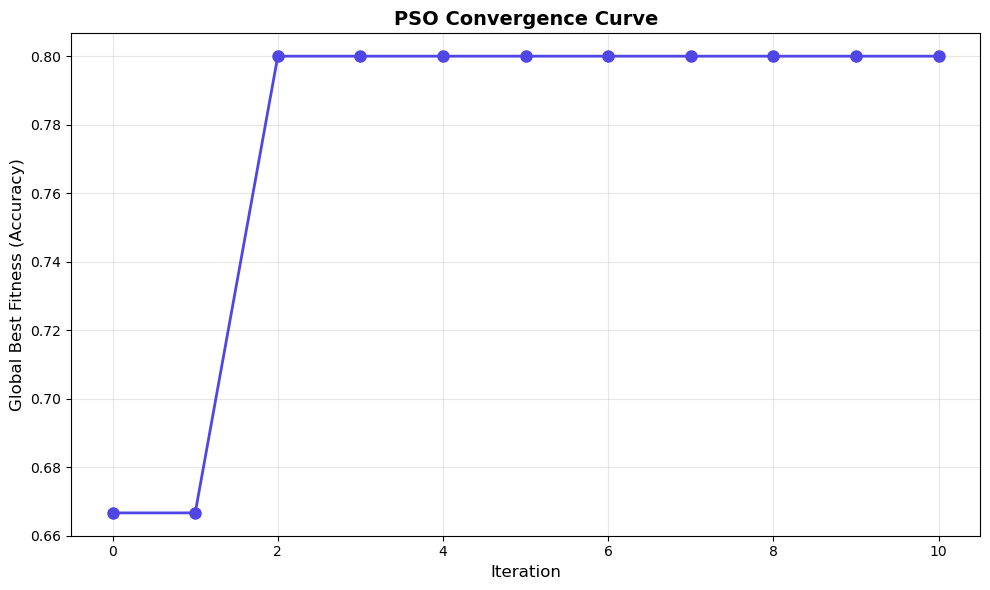


COMPARISON WITH ALL FEATURES
Accuracy with ALL features: 0.7667
Accuracy with SELECTED features: 0.8000
Improvement: 0.0333


In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class PSOFeatureSelection:
    def __init__(self, n_particles=3, n_features=5, max_iter=10, w=0.7, c1=2.0, c2=2.0):
        """
        Initialize PSO for Feature Selection
        
        Parameters:
        - n_particles: Number of particles in the swarm
        - n_features: Number of features in the dataset
        - max_iter: Maximum number of iterations
        - w: Inertia weight
        - c1: Cognitive coefficient (personal influence)
        - c2: Social coefficient (global influence)
        """
        self.n_particles = n_particles
        self.n_features = n_features
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        
        # Initialize particles
        self.particles = []
        self.velocities = []
        self.pbest_positions = []
        self.pbest_fitness = []
        self.gbest_position = None
        self.gbest_fitness = -np.inf
        
        # History for tracking
        self.fitness_history = []
        self.gbest_history = []
        
    def sigmoid(self, x):
        """Sigmoid function for binary conversion"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def initialize_particles(self):
        """Initialize particles with example positions from slides"""
        # Using the exact initial positions from the slides
        initial_positions = [
            [1, 0, 1, 0, 1],
            [0, 1, 1, 0, 0],
            [1, 1, 0, 1, 0]
        ]
        
        initial_velocities = [
            [0.2, -0.1, 0.3, -0.2, 0.1],
            [-0.1, 0.2, 0.1, -0.3, -0.2],
            [0.1, 0.1, -0.2, 0.3, -0.1]
        ]
        
        self.particles = [np.array(pos) for pos in initial_positions]
        self.velocities = [np.array(vel) for vel in initial_velocities]
        
        # Initialize pbest as current positions
        self.pbest_positions = [pos.copy() for pos in self.particles]
        
    def calculate_fitness(self, position, X_train, y_train, X_test, y_test):
        """
        Calculate fitness using Decision Tree classifier
        Fitness = accuracy on test set
        """
        # Get selected features (where position = 1)
        selected_features = np.where(position == 1)[0]
        
        # If no features selected, return 0
        if len(selected_features) == 0:
            return 0.0
        
        # Train classifier with selected features
        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]
        
        clf = DecisionTreeClassifier(random_state=42, max_depth=5)
        clf.fit(X_train_selected, y_train)
        
        # Calculate accuracy
        y_pred = clf.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        
        return accuracy
    
    def update_velocity_and_position(self, particle_idx, r1=0.5, r2=0.3):
        """Update velocity and position for a particle"""
        particle = self.particles[particle_idx]
        velocity = self.velocities[particle_idx]
        pbest = self.pbest_positions[particle_idx]
        
        # Update velocity using PSO formula
        # V[t+1] = w*V[t] + c1*r1*(pbest - X) + c2*r2*(gbest - X)
        inertia = self.w * velocity
        cognitive = self.c1 * r1 * (pbest - particle)
        social = self.c2 * r2 * (self.gbest_position - particle)
        
        new_velocity = inertia + cognitive + social
        
        # Update position using sigmoid for binary conversion
        sigmoid_values = self.sigmoid(new_velocity)
        new_position = (np.random.rand(self.n_features) < sigmoid_values).astype(int)
        
        self.velocities[particle_idx] = new_velocity
        self.particles[particle_idx] = new_position
        
        return new_position, new_velocity
    
    def optimize(self, X_train, y_train, X_test, y_test):
        """Run PSO optimization"""
        print("=" * 70)
        print("PSO FEATURE SELECTION - BASED ON LEC5.PDF")
        print("=" * 70)
        print(f"\nParameters: w={self.w}, c1={self.c1}, c2={self.c2}")
        print(f"Particles: {self.n_particles}, Features: {self.n_features}, Max Iterations: {self.max_iter}")
        print("\n" + "=" * 70)
        
        # Initialize particles
        self.initialize_particles()
        
        # Calculate initial fitness for all particles
        print("\n>>> INITIALIZATION <<<")
        print("-" * 70)
        for i in range(self.n_particles):
            fitness = self.calculate_fitness(self.particles[i], X_train, y_train, X_test, y_test)
            self.pbest_fitness.append(fitness)
            
            print(f"\nParticle {i+1}:")
            print(f"  Position: {self.particles[i]}")
            print(f"  Velocity: {self.velocities[i]}")
            print(f"  Fitness:  {fitness:.4f}")
            
            # Update global best
            if fitness > self.gbest_fitness:
                self.gbest_fitness = fitness
                self.gbest_position = self.particles[i].copy()
        
        selected_features = np.where(self.gbest_position == 1)[0] + 1
        print(f"\n>>> INITIAL GLOBAL BEST <<<")
        print(f"  Position: {self.gbest_position}")
        print(f"  Fitness:  {self.gbest_fitness:.4f}")
        print(f"  Selected Features: {list(selected_features)}")
        
        self.fitness_history.append([self.pbest_fitness.copy()])
        self.gbest_history.append(self.gbest_fitness)
        
        # Main PSO loop
        for iteration in range(self.max_iter):
            print("\n" + "=" * 70)
            print(f">>> ITERATION {iteration + 1} <<<")
            print("-" * 70)
            
            iteration_fitness = []
            
            for i in range(self.n_particles):
                # Update velocity and position
                r1 = np.random.rand()
                r2 = np.random.rand()
                new_position, new_velocity = self.update_velocity_and_position(i, r1, r2)
                
                # Calculate fitness
                fitness = self.calculate_fitness(new_position, X_train, y_train, X_test, y_test)
                iteration_fitness.append(fitness)
                
                print(f"\nParticle {i+1}:")
                print(f"  New Position: {new_position}")
                print(f"  New Velocity: {np.round(new_velocity, 3)}")
                print(f"  New Fitness:  {fitness:.4f}")
                
                # Update personal best
                if fitness > self.pbest_fitness[i]:
                    self.pbest_fitness[i] = fitness
                    self.pbest_positions[i] = new_position.copy()
                    print(f"  ✓ Personal best updated!")
                
                print(f"  pBest: {self.pbest_positions[i]} (fitness: {self.pbest_fitness[i]:.4f})")
                
                # Update global best
                if fitness > self.gbest_fitness:
                    self.gbest_fitness = fitness
                    self.gbest_position = new_position.copy()
                    print(f"  🏆 GLOBAL BEST UPDATED!")
            
            selected_features = np.where(self.gbest_position == 1)[0] + 1
            print(f"\n>>> GLOBAL BEST AFTER ITERATION {iteration + 1} <<<")
            print(f"  Position: {self.gbest_position}")
            print(f"  Fitness:  {self.gbest_fitness:.4f}")
            print(f"  Selected Features: {list(selected_features)}")
            
            self.fitness_history.append(iteration_fitness)
            self.gbest_history.append(self.gbest_fitness)
        
        print("\n" + "=" * 70)
        print(">>> FINAL RESULTS <<<")
        print("=" * 70)
        selected_features = np.where(self.gbest_position == 1)[0] + 1
        print(f"\nBest Feature Subset: {self.gbest_position}")
        print(f"Selected Features (indices): {list(selected_features)}")
        print(f"Best Fitness (Accuracy): {self.gbest_fitness:.4f}")
        print(f"Number of Features Selected: {np.sum(self.gbest_position)}/{self.n_features}")
        
        return self.gbest_position, self.gbest_fitness
    
    def plot_convergence(self):
        """Plot convergence curve"""
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(self.gbest_history)), self.gbest_history, 
                marker='o', linewidth=2, markersize=8, color='#4F46E5')
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Global Best Fitness (Accuracy)', fontsize=12)
        plt.title('PSO Convergence Curve', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


def create_sample_dataset(n_samples=200, n_features=5, random_state=42):
    """Create a sample dataset for demonstration"""
    np.random.seed(random_state)
    
    # Create synthetic data where features 1, 3, 4 are most important
    X = np.random.randn(n_samples, n_features)
    
    # Create target based on important features
    y = (X[:, 0] + X[:, 2] * 1.5 + X[:, 3] * 2 + np.random.randn(n_samples) * 0.5) > 0
    y = y.astype(int)
    
    return X, y


def main():
    """Main function to run PSO Feature Selection"""
    
    # Create sample dataset
    print("Creating sample dataset...")
    X, y = create_sample_dataset(n_samples=200, n_features=5, random_state=42)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    print(f"Dataset shape: {X.shape}")
    print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
    
    # Initialize PSO
    pso = PSOFeatureSelection(
        n_particles=3,
        n_features=5,
        max_iter=10,
        w=0.7,
        c1=2.0,
        c2=2.0
    )
    
    # Run optimization
    best_features, best_fitness = pso.optimize(X_train, y_train, X_test, y_test)
    
    # Plot convergence
    print("\nGenerating convergence plot...")
    pso.plot_convergence()
    
    # Compare with using all features
    print("\n" + "=" * 70)
    print("COMPARISON WITH ALL FEATURES")
    print("=" * 70)
    clf_all = DecisionTreeClassifier(random_state=42, max_depth=5)
    clf_all.fit(X_train, y_train)
    y_pred_all = clf_all.predict(X_test)
    accuracy_all = accuracy_score(y_test, y_pred_all)
    print(f"Accuracy with ALL features: {accuracy_all:.4f}")
    print(f"Accuracy with SELECTED features: {best_fitness:.4f}")
    print(f"Improvement: {(best_fitness - accuracy_all):.4f}")


if __name__ == "__main__":
    main()